<a href="https://colab.research.google.com/github/virarkh/customer-segmentation-using-RFM-K-Means/blob/master/Skripsi_Segmentasi_Pelanggan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
# pip install feature-engine

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
from datetime import datetime
from datetime import timedelta
from datetime import time

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

import feature_engine
from feature_engine.outliers import Winsorizer
from scipy.stats.mstats import winsorize

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

### Data Profiling

In [5]:
sheet_id = '1-rPoksqtegeqEkaFvGGMlpcFqfxx1gai-SicUizB4q4'
xls = pd.ExcelFile(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx')

df = pd.read_excel(xls, 'Dataset')

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_no    457 non-null    object        
 1   order_time  457 non-null    datetime64[ns]
 2   qty         457 non-null    int64         
 3   amount      457 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 14.4+ KB


In [7]:
# export raw data of df dataframe
# df.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\raw_data.csv')

### Exploratory Data Analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty,457.0,3.345733,6.558003,1.0,1.0,2.0,3.0,75.0
amount,457.0,33457.330416,65580.027079,10000.0,10000.0,20000.0,30000.0,750000.0


In [9]:
df_monthly = df.copy()
df_monthly.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [10]:
# mengubah format tanggal transaksi
df_monthly['order_time'] = pd.to_datetime(df_monthly['order_time'], format='%Y-%m-%d')

# mengelompokkan data berdasarkan bulan dan tahun
df_monthly = df_monthly.set_index('order_time').resample('M').sum().reset_index()

df_monthly

,order_time,qty,amount
0,2021-01-31,100,1000000
1,2021-02-28,140,1400000
2,2021-03-31,176,1760000
3,2021-04-30,79,790000
4,2021-05-31,103,1030000
5,2021-06-30,0,0
6,2021-07-31,50,500000
7,2021-08-31,230,2300000
8,2021-09-30,32,320000
9,2021-10-31,240,2400000


In [11]:
# export df_monthly dataframe
# df_monthly.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\monthly_sales.csv')

In [12]:
# membuat linechart menggunakan pyplot
plot_order = [
    go.Scatter(
        x = df_monthly['order_time'],
        y = df_monthly['qty'],
        mode = 'lines+markers'
    )
]

plot_layout = go.Layout(
#     xaxis = {'type': 'category', 'tickformat': '%Y/%m'},
    xaxis = {'tickformat': '%Y-%m-%d'},
    xaxis_title = 'Bulan',
    yaxis_title = 'Jumlah Penjualan',
    title = 'Tren Penjualan Energy Bar di Bulan Januari 2021 - Februari 2022'
)

fig = go.Figure(data=plot_order, layout=plot_layout)
fig.update_layout(plot_layout)
fig.show()

# Data Preparation

### Data Cleansing

In [13]:
# mengubah tipe data pada akolom qty dan price dari float ke int
df[['qty', 'amount']] = df[['qty', 'amount']].astype(float).astype(int)

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [14]:
dataset = df.copy()

### RFM Scoring

In [15]:
# timebound
print(dataset['order_time'].min())
print(dataset['order_time'].max())

2021-01-02 15:18:40
2022-02-24 16:08:23


In [16]:
now = dt.date(2022, 2, 24)
dataset['Date'] = pd.DatetimeIndex(dataset.order_time).date

In [17]:
# Recency
df_recency = dataset.groupby(['order_no'],as_index=False)['Date'].max()
df_recency.columns = ['order_no','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(now - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,order_no,Recency
0,065321010200000076,418
1,065321010600000078,414
2,065321010800000080,412
3,065321010800000082,412
4,065321010800000085,412


In [18]:
# Frequency & Monetary
df_fm = dataset.groupby('order_no').agg({'order_no':lambda x:len(x),
                                    'amount':lambda x:sum(x)})
df_fm.rename(columns = {'order_no' :'Frequency',
                        'amount':'Monetary'},inplace= True)
df_fm.head()

,Frequency,Monetary
order_no,,
065321010200000076,2,20000
065321010600000078,2,20000
065321010800000080,1,10000
065321010800000082,2,200000
065321010800000085,2,100000


In [19]:
RFM_Table = df_recency.merge(df_fm,left_on='order_no',right_on='order_no')
RFM_Table.head()

,order_no,Recency,Frequency,Monetary
0,065321010200000076,418,2,20000
1,065321010600000078,414,2,20000
2,065321010800000080,412,1,10000
3,065321010800000082,412,2,200000
4,065321010800000085,412,2,100000


In [20]:
RFM_Table_New = RFM_Table.drop(['order_no'], axis=1)

In [21]:
# RFM_Table_New = RFM_Table.copy()

In [22]:
RFM_Table_New.head()

,Recency,Frequency,Monetary
0,418,2,20000
1,414,2,20000
2,412,1,10000
3,412,2,200000
4,412,2,100000


In [23]:
RFM_Table_New.describe()

,Recency,Frequency,Monetary
count,260.000000,260.000000,2.600000e+02
mean,220.753846,1.757692,5.880769e+04
std,125.227796,0.429306,1.196509e+05
min,0.000000,1.000000,1.000000e+04
25%,115.000000,2.000000,2.000000e+04
50%,201.000000,2.000000,3.000000e+04
75%,338.250000,2.000000,4.000000e+04
max,418.000000,2.000000,1.500000e+06


In [24]:
# RFM_Table.to_csv(r'C:\Users\ACER\SKRIPSI\data_rfm.csv')

### Deteksi Outlier

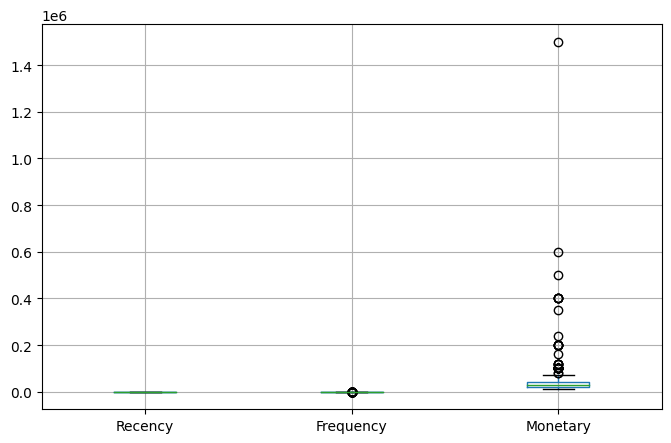

In [25]:
plt.figure(figsize=(8, 5))
RFM_Table_New.boxplot()
plt.show()

In [26]:
# hitung batas atas dan batas bawah untuk setiap variabel
q1 = RFM_Table_New.quantile(0.25)
q3 = RFM_Table_New.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [27]:
lower_bound

Recency       -219.875
Frequency        2.000
Monetary    -10000.000
dtype: float64

In [28]:
upper_bound

Recency        673.125
Frequency        2.000
Monetary     70000.000
dtype: float64

In [29]:
# winsorize data menggunakan batas atas dan batas bawah yang sudah dihitung
data_winsorized = pd.DataFrame()
for col in RFM_Table_New.columns:
    data_winsorized[col] = winsorize(RFM_Table_New[col], limits=0.05)
#     data_winsorized[col] = winsorize(RFM_Table_New[col], limits=(lower_bound[col], upper_bound[col]))

In [30]:
# tampilkan data asli dan data yang sudah di-winsorize
print('Data Asli:')
print(RFM_Table_New)

print('\nData Winsorized:')
print(data_winsorized)

Data Asli:
     Recency  Frequency  Monetary
0        418          2     20000
1        414          2     20000
2        412          1     10000
3        412          2    200000
4        412          2    100000
..       ...        ...       ...
255        2          2     30000
256        0          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    500000

[260 rows x 3 columns]

Data Winsorized:
     Recency  Frequency  Monetary
0        406          2     20000
1        406          2     20000
2        406          1     10000
3        406          2    200000
4        406          2    100000
..       ...        ...       ...
255       17          2     30000
256       17          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    200000

[260 rows x 3 columns]


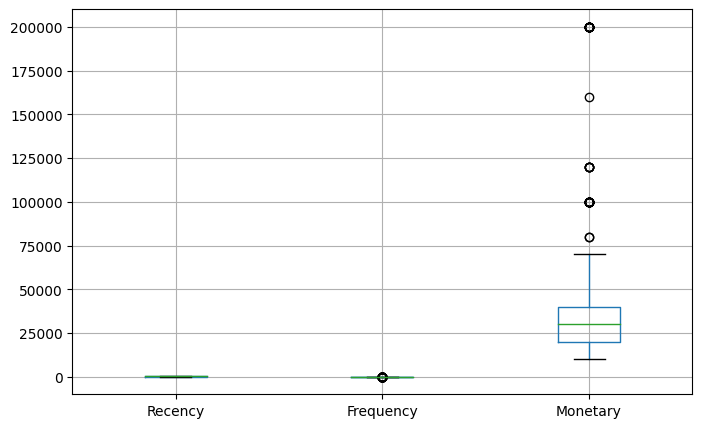

In [31]:
plt.figure(figsize=(8, 5))
data_winsorized.boxplot()
plt.show()

In [32]:
df_rfm = data_winsorized.copy()

In [33]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,260.000000,260.000000,260.000000
mean,221.011538,1.757692,46538.461538
std,124.076433,0.429306,48286.652727
min,17.000000,1.000000,10000.000000
25%,115.000000,2.000000,20000.000000
50%,201.000000,2.000000,30000.000000
75%,338.250000,2.000000,40000.000000
max,406.000000,2.000000,200000.000000


In [34]:
df_rfm.shape

(260, 3)

In [35]:
# export preprocessing data of df dataframe
# df_rfm.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\preprocessing_data.csv')

### Transformasi Data

In [36]:
df_rfm_new = df_rfm.copy()
df_rfm_new.head()

,Recency,Frequency,Monetary
0,406,2,20000
1,406,2,20000
2,406,1,10000
3,406,2,200000
4,406,2,100000


In [37]:
df_rfm_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    260 non-null    int64
 1   Frequency  260 non-null    int64
 2   Monetary   260 non-null    int64
dtypes: int64(3)
memory usage: 6.2 KB


In [38]:
df_rfm_new = np.log(df_rfm_new+1)

In [39]:
windsoriser = Winsorizer(tail='both',
                         fold=2,
                         variables=['Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_new)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [40]:
df_rfm_new = windsoriser.transform(df_rfm_new)

In [41]:
scaler = StandardScaler()
scaler.fit(df_rfm_new)
df_rfm_scaled = scaler.transform(df_rfm_new)

In [42]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=df_rfm.columns)
df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.084883,0.565506,-0.574239
1,1.084883,0.565506,-0.574239
2,1.084883,-1.768328,-1.446730
3,1.084883,0.565506,2.079966
4,1.084883,0.565506,1.451719


In [43]:
df_rfm_scaled.shape

(260, 3)

In [44]:
df_rfm_scaled = df_rfm_scaled.round(6)

df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.084883,0.565506,-0.574239
1,1.084883,0.565506,-0.574239
2,1.084883,-1.768328,-1.446730
3,1.084883,0.565506,2.079966
4,1.084883,0.565506,1.451719


In [45]:
# export standar scaller data of df dataframe
df_rfm_scaled.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\scaler.csv')

# Modeling

In [46]:
X = np.asarray(df_rfm_scaled)

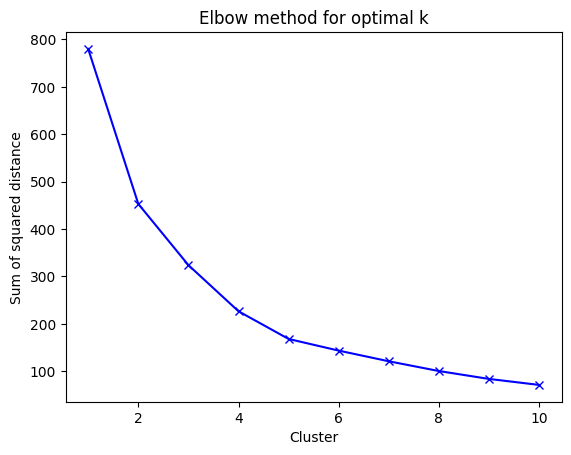

In [47]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')
plt.title('Elbow method for optimal k')
plt.show()

In [48]:
# Menampilkan nilai SSE untuk setiap jumlah kluster
for k, sse in zip(K, Sum_of_squared_distances):
    print("Number of clusters:", k)
    print("SSE:", sse)
    print("\n")

Number of clusters: 1
SSE: 780.0000776044142


Number of clusters: 2
SSE: 452.94908692291466


Number of clusters: 3
SSE: 323.80956593532215


Number of clusters: 4
SSE: 226.40910103775528


Number of clusters: 5
SSE: 167.9758077602919


Number of clusters: 6
SSE: 143.40048291799604


Number of clusters: 7
SSE: 120.90085175175483


Number of clusters: 8
SSE: 100.29041955803896


Number of clusters: 9
SSE: 83.65815736052231


Number of clusters: 10
SSE: 71.01293146715916




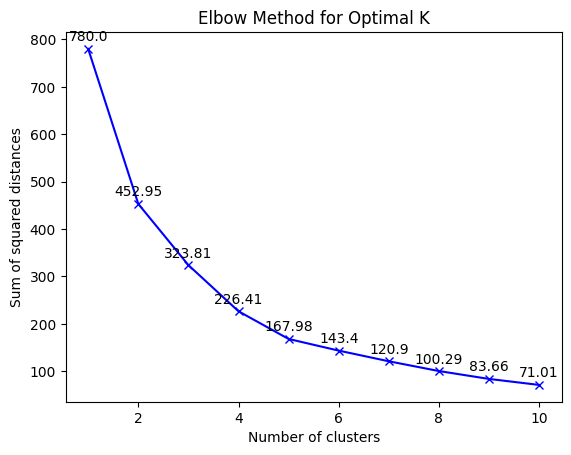

In [49]:
# Plot elbow graph with SSE values
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K')
# plt.show()

# Add SSE values as text above each cluster point
for k, sse in zip(K, Sum_of_squared_distances):
    plt.text(k, sse + 10, str(round(sse, 2)), ha='center', va='bottom')

plt.show()

# Evaluation

In [50]:
model_kmeans_2 = KMeans(n_clusters = 2)
model_kmeans_2.fit(X)

KMeans(n_clusters=2)

In [51]:
model_kmeans_3 = KMeans(n_clusters = 3)
model_kmeans_3.fit(X)

KMeans(n_clusters=3)

In [52]:
model_kmeans_4 = KMeans(n_clusters = 4)
model_kmeans_4.fit(X)

KMeans(n_clusters=4)

In [53]:
model_kmeans_5 = KMeans(n_clusters = 5)
model_kmeans_5.fit(X)

KMeans(n_clusters=5)

In [54]:
model_kmeans_6 = KMeans(n_clusters = 6)
model_kmeans_6.fit(X)

KMeans(n_clusters=6)

In [55]:
model_kmeans_7 = KMeans(n_clusters = 7)
model_kmeans_7.fit(X)

KMeans(n_clusters=7)

In [56]:
model_kmeans_8 = KMeans(n_clusters = 8)
model_kmeans_8.fit(X)

KMeans()

In [57]:
model_kmeans_9 = KMeans(n_clusters = 9)
model_kmeans_9.fit(X)

KMeans(n_clusters=9)

In [58]:
model_kmeans_10 = KMeans(n_clusters = 10)
model_kmeans_10.fit(X)

KMeans(n_clusters=10)

<hr>

In [59]:
# davies_bouldin_score

In [60]:
print(davies_bouldin_score(X, model_kmeans_2.labels_))

0.900800347164028


In [61]:
print(davies_bouldin_score(X, model_kmeans_3.labels_))

1.0111675960062307


In [62]:
print(davies_bouldin_score(X, model_kmeans_4.labels_))

0.7653054819296347


In [63]:
print(davies_bouldin_score(X, model_kmeans_5.labels_))

0.7995082017245391


In [64]:
print(davies_bouldin_score(X, model_kmeans_6.labels_))

0.8824344979938626


In [65]:
print(davies_bouldin_score(X, model_kmeans_7.labels_))

0.8575868997507853


In [66]:
print(davies_bouldin_score(X, model_kmeans_8.labels_))

0.7791942411160111


In [67]:
print(davies_bouldin_score(X, model_kmeans_9.labels_))

0.7463390205509978


In [68]:
print(davies_bouldin_score(X, model_kmeans_10.labels_))

0.7006099337766056


# Deployment

In [69]:
# labeling
df_clustered = pd.DataFrame(RFM_Table)
df_clustered['cluster'] = pd.DataFrame(model_kmeans_4.labels_)
df_clustered = df_clustered.sort_values('cluster')
data_clustered = np.asarray(df_clustered)

data_clustered

array([['06C922010400000590', 51, 2, 20000, 0],
       ['06C921102800000354', 119, 2, 40000, 0],
       ['06C922010400000591', 51, 2, 20000, 0],
       ...,
       ['E39421022200000110', 367, 2, 30000, 3],
       ['E39421041400000220', 316, 2, 30000, 3],
       ['065321010200000076', 418, 2, 20000, 3]], dtype=object)

In [70]:
cluster_labels = model_kmeans_4.labels_

In [71]:
rfm_labels_4 = RFM_Table.assign(cluster = cluster_labels)

rfm_labels_4.head()

,order_no,Recency,Frequency,Monetary,cluster
0,065321010200000076,418,2,20000,3
1,065321010600000078,414,2,20000,3
2,065321010800000080,412,1,10000,1
3,065321010800000082,412,2,200000,2
4,065321010800000085,412,2,100000,2


In [72]:
rfm_labels_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   order_no   260 non-null    object
 1   Recency    260 non-null    int64 
 2   Frequency  260 non-null    int64 
 3   Monetary   260 non-null    int64 
 4   cluster    260 non-null    int32 
dtypes: int32(1), int64(3), object(1)
memory usage: 11.2+ KB


In [73]:
# export dataframe after clustering
# rfm_labels_4.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\all_cluster_data.csv')

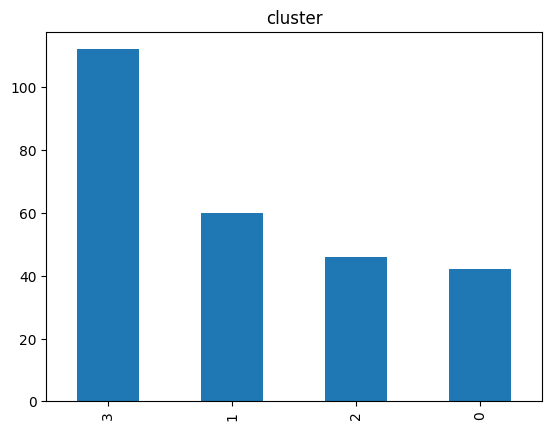

In [74]:
rfm_labels_4['cluster'].value_counts().plot(kind='bar');
plt.title('cluster');

In [75]:
df_clustered

,order_no,Recency,Frequency,Monetary,cluster
129,06C922010400000590,51,2,20000,0
86,06C921102800000354,119,2,40000,0
130,06C922010400000591,51,2,20000,0
90,06C921110100000361,115,2,40000,0
92,06C921110200000367,114,2,20000,0
...,...,...,...,...,...
168,E39421022300000113,366,2,20000,3
167,E39421022300000112,366,2,20000,3
166,E39421022200000110,367,2,30000,3
198,E39421041400000220,316,2,30000,3


In [76]:
cluster_0 = df_clustered.loc[df_clustered['cluster'] == 0]

cluster_0.head()

,order_no,Recency,Frequency,Monetary,cluster
129,06C922010400000590,51,2,20000,0
86,06C921102800000354,119,2,40000,0
130,06C922010400000591,51,2,20000,0
90,06C921110100000361,115,2,40000,0
92,06C921110200000367,114,2,20000,0


In [77]:
# export cluster 0 dataframe
cluster_0.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_0.csv')

In [78]:
cluster_1 = df_clustered.loc[df_clustered['cluster'] == 1]

cluster_1.head()

,order_no,Recency,Frequency,Monetary,cluster
89,06C921110100000360,115,1,10000,1
88,06C921102900000356,118,1,20000,1
239,E39422020300000508,21,1,10000,1
238,E39422020300000507,21,1,10000,1
91,06C921110100000366,115,1,10000,1


In [79]:
# export cluster 1 dataframe
# cluster_1.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_1.csv')

In [80]:
cluster_2 = df_clustered.loc[df_clustered['cluster'] == 2]

cluster_2.head()

,order_no,Recency,Frequency,Monetary,cluster
196,E39421041400000218,316,2,100000,2
212,E39421051100000343,289,2,100000,2
193,E39421040800000212,322,2,100000,2
225,E39421052700000424,273,2,100000,2
226,E39421053100000431,269,2,400000,2


In [81]:
# export cluster 2 dataframe
# cluster_2.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_2.csv')

In [82]:
cluster_3 = df_clustered.loc[df_clustered['cluster'] == 3]

cluster_3.head()

,order_no,Recency,Frequency,Monetary,cluster
215,E39421051100000357,289,2,40000,3
216,E39421051100000362,289,2,40000,3
217,E39421051100000384,289,2,20000,3
219,E39421052100000397,279,2,40000,3
214,E39421051100000356,289,2,40000,3


In [83]:
# export cluster 3 dataframe
# cluster_3.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_3.csv')

In [84]:
cluster_0.shape

(42, 5)

In [85]:
cluster_1.shape

(60, 5)

In [86]:
cluster_2.shape

(46, 5)

In [87]:
cluster_3.shape

(112, 5)

In [88]:
cluster_0.describe()

,Recency,Frequency,Monetary,cluster
count,42.000000,42.000000,42.000000,42.0
mean,57.833333,1.976190,36428.571429,0.0
std,38.182435,0.154303,20579.581234,0.0
min,0.000000,1.000000,20000.000000,0.0
25%,14.750000,2.000000,20000.000000,0.0
50%,62.500000,2.000000,35000.000000,0.0
75%,90.000000,2.000000,40000.000000,0.0
max,119.000000,2.000000,100000.000000,0.0


In [89]:
cluster_1.describe()

,Recency,Frequency,Monetary,cluster
count,60.000000,60.0,60.000000,60.0
mean,222.500000,1.0,16500.000000,1.0
std,134.893618,0.0,10865.120683,0.0
min,2.000000,1.0,10000.000000,1.0
25%,112.000000,1.0,10000.000000,1.0
50%,190.000000,1.0,10000.000000,1.0
75%,362.000000,1.0,20000.000000,1.0
max,412.000000,1.0,50000.000000,1.0


In [90]:
cluster_2.describe()

,Recency,Frequency,Monetary,cluster
count,46.000000,46.000000,4.600000e+01,46.0
mean,249.804348,1.956522,2.052174e+05,2.0
std,117.660268,0.206185,2.338826e+05,0.0
min,49.000000,1.000000,7.000000e+04,2.0
25%,135.500000,2.000000,1.000000e+05,2.0
50%,271.000000,2.000000,1.000000e+05,2.0
75%,350.500000,2.000000,2.000000e+05,2.0
max,412.000000,2.000000,1.500000e+06,2.0


In [91]:
cluster_3.describe()

,Recency,Frequency,Monetary,cluster
count,112.000000,112.0,112.000000,112.0
mean,268.982143,2.0,29732.142857,3.0
std,89.592871,0.0,10777.004333,0.0
min,126.000000,2.0,20000.000000,3.0
25%,190.000000,2.0,20000.000000,3.0
50%,289.000000,2.0,20000.000000,3.0
75%,343.500000,2.0,40000.000000,3.0
max,418.000000,2.0,50000.000000,3.0
